In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('DataSets/cola_production.csv')
print(df.isnull().sum())
df.info()
df.head()

Month    0
cola     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   476 non-null    object 
 1   cola    476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


,Month,cola
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [49]:
#converting Month in proper format (1956-01)
df['monthYear'] = pd.to_datetime(df['Month'])
# df.info()
df.set_index('monthYear', inplace=True)
df.head()

,Month,cola,rollMean,rollSTD,rollStd
monthYear,,,,,
1956-01-01,1956-01,93.2,NaN,NaN,NaN
1956-02-01,1956-02,96.0,NaN,NaN,NaN
1956-03-01,1956-03,95.2,NaN,NaN,NaN
1956-04-01,1956-04,77.1,NaN,NaN,NaN
1956-05-01,1956-05,70.9,NaN,NaN,NaN


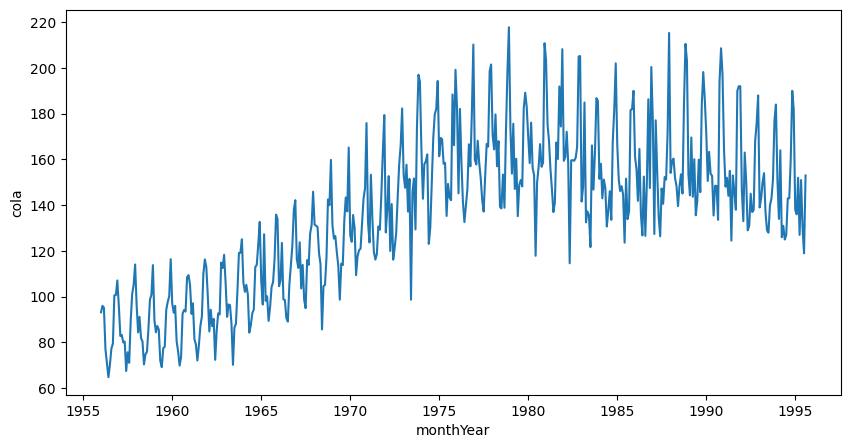

In [15]:
#visulize time serise
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x=df.index, y=df.cola)
plt.show()

C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_17104\209183884.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


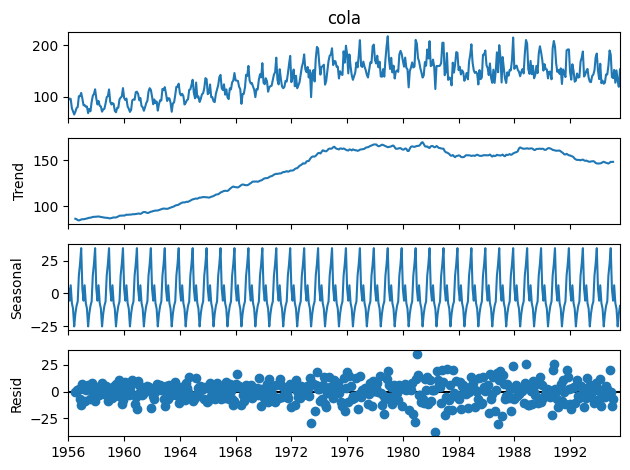

In [16]:
# checking for seasonality and trend by doing decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.cola)
plot = decomposition.plot()
plot.show()

(np.float64(-2.282661418787573), np.float64(0.17762099829132627), 17, 458, {'1%': np.float64(-3.4447087976702284), '5%': np.float64(-2.867871300049488), '10%': np.float64(-2.5701423432047443)}, np.float64(3463.9034375936567))
ADF value: 0.1776
time serise is not stationary(H0 not accept)


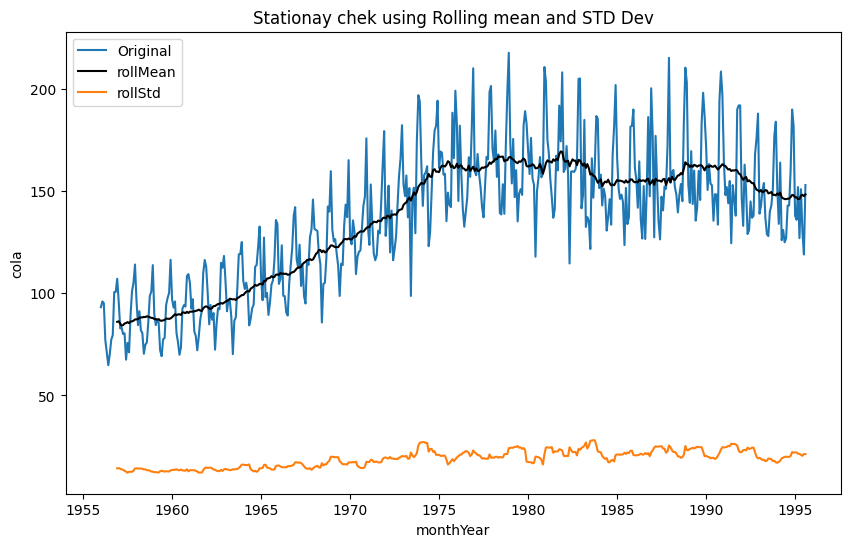

In [21]:
#cheking wheater time serise is stationary or not
#rolling mean anad std dev for 12 month
from statsmodels.tsa.stattools import adfuller
def test_stationarity(dataframe, col):
    df['rollMean'] = dataframe[col].rolling(window=12).mean()
    df['rollStd'] = dataframe[col].rolling(window=12).std()

    adf_result = adfuller(dataframe[col])
    print(adf_result)
    p_value = adf_result[1]

    print(f"ADF value: {p_value:.4f}")

    if p_value < 0.05:
        print("time serise is stationary(H0 accept)")
    else:
        print("time serise is not stationary(H0 not accept)")

      #plot original serise with rolling mean and std
    plt.figure(figsize=(10,6))
    sns.lineplot(data = df, x=df.index, y=df.cola, label = 'Original')
    sns.lineplot(data = df, x=df.index, y=df.rollMean, label = 'rollMean', color = 'black')
    sns.lineplot(data = df, x=df.index, y=df.rollStd, label = 'rollStd')
    plt.title("Stationay chek using Rolling mean and STD Dev")
    plt.show()
    # print(df.tail())

test_stationarity(df, 'cola')


            cola  shift  shiftDiff
monthYear                         
1956-01-01  93.2    NaN        NaN
1956-02-01  96.0   93.2        2.8
1956-03-01  95.2   96.0       -0.8
1956-04-01  77.1   95.2      -18.1
1956-05-01  70.9   77.1       -6.2
(np.float64(-4.980663743064756), np.float64(2.423411785996464e-05), 18, 456, {'1%': np.float64(-3.4447721346720885), '5%': np.float64(-2.8678991615065095), '10%': np.float64(-2.570157193174823)}, np.float64(3455.3553857680226))
ADF value: 0.0000
time serise is stationary(H0 accept)


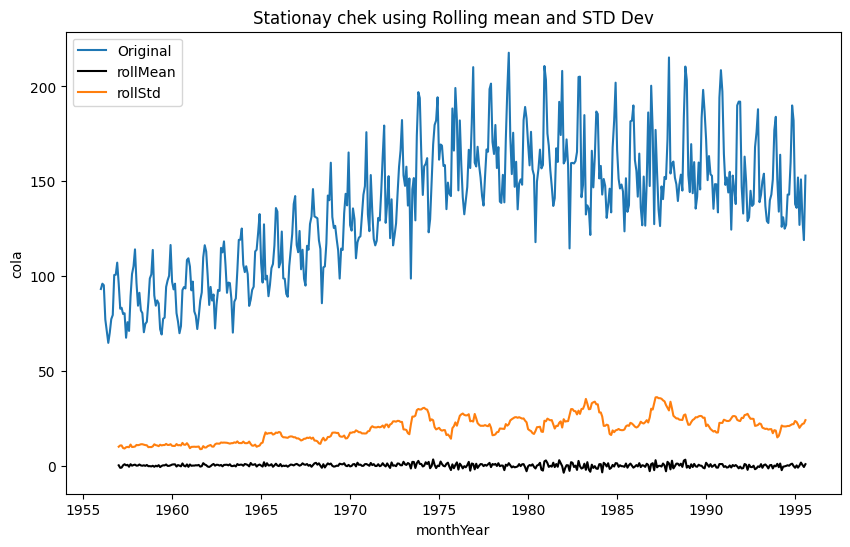

In [26]:
#making data stesionry

cola_df = df[['cola']].copy()
cola_df.head()

# try a shift-diff of 1
cola_df['shift'] = cola_df.cola.shift(1)
cola_df['shiftDiff'] = cola_df['cola'] - cola_df['shift']
print(cola_df.head())

test_stationarity(cola_df.dropna(), 'shiftDiff')

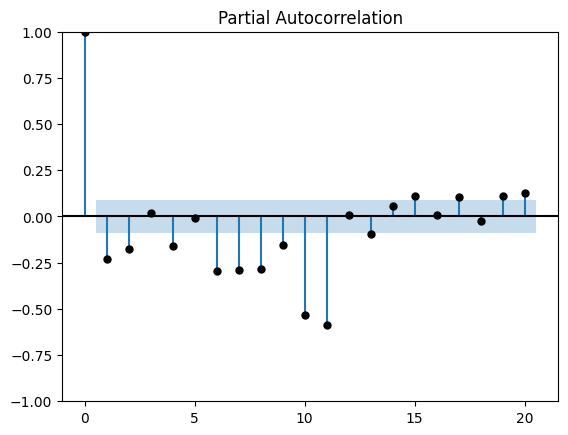

In [27]:
#ARIMA 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(cola_df['shiftDiff'].dropna(), lags=20, color = 'black')
plt.show()

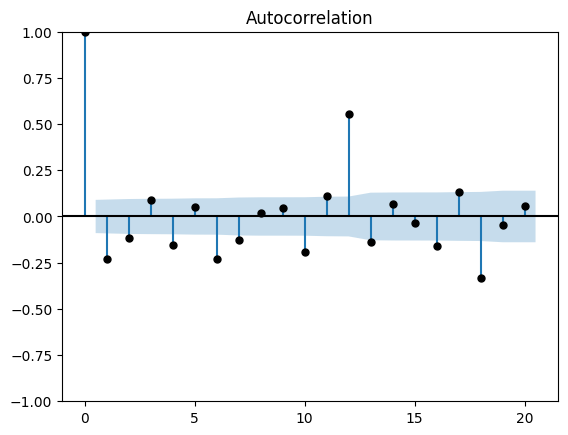

In [28]:

plot_acf(cola_df['shiftDiff'].dropna(), lags=20, color = 'black')
plt.show()

In [29]:
#Build ARIMA Model
train = cola_df[:round(len(cola_df) * 70/100)]
print(train.tail())

             cola  shift  shiftDiff
monthYear                          
1983-05-01  137.3  132.5        4.8
1983-06-01  135.5  137.3       -1.8
1983-07-01  121.7  135.5      -13.8
1983-08-01  166.1  121.7       44.4
1983-09-01  146.8  166.1      -19.3


In [ ]:
test = cola_df[round(len(cola_df) * 70/100):]
print(test.tail())

             cola  shift  shiftDiff
monthYear                          
1995-04-01  127.0  152.0      -25.0
1995-05-01  151.0  127.0       24.0
1995-06-01  130.0  151.0      -21.0
1995-07-01  119.0  130.0      -11.0
1995-08-01  153.0  119.0       34.0


In [51]:
model = ARIMA(train['cola'], order=(1,1,1))
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0], end=test.index[-1])
cola_df['arimaPred'] = prediction
cola_df['PredDiff'] = cola_df['arimaPred'] - cola_df['cola']
# print(cola_df.tail(30))

c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


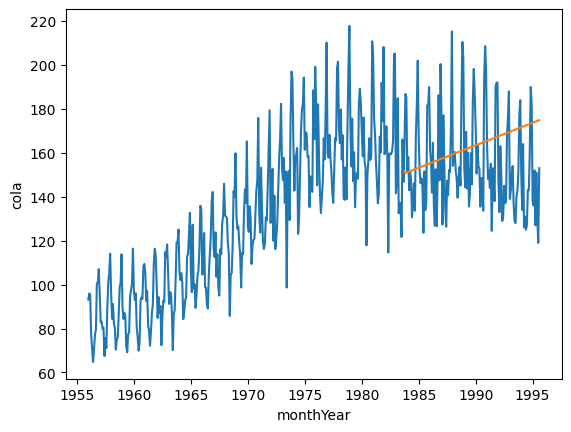

In [ ]:
#Plotting the  ARIMA
sns.lineplot(data=cola_df, x = cola_df.index, y='cola')
sns.lineplot(data=cola_df, x = cola_df.index, y='arimaPred')
plt.show()

In [44]:
#SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarimax = SARIMAX(train['cola'],order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model_sarimax.fit()
prediction_s = model_fit.predict(start=test.index[0], end=test.index[-1])
cola_df['sarimaxPred'] = prediction_s
# air_df['PredDiff'] = air_df['arimaPred'] - air_df['cola']


c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


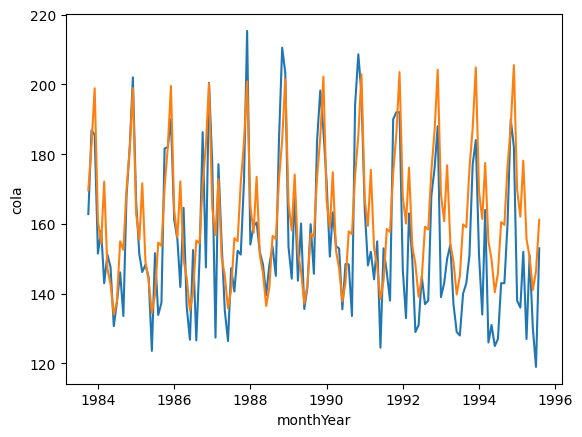

In [45]:
#Plotting the  ARIMA
sns.lineplot(data=cola_df, x = cola_df.index, y='cola')
sns.lineplot(data=cola_df, x = cola_df.index, y='sarimaxPred')
plt.show()

In [46]:
# sarimax Evaluation
cola_df = cola_df.dropna()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(cola_df['cola'], cola_df['sarimaxPred'])
rmae = mean_squared_error(cola_df['cola'], cola_df['sarimaxPred'])
r2 = r2_score(cola_df['cola'], cola_df['sarimaxPred'])

print(f"ARMIS MAE: {mae}, RMAE: {rmae}, r2: {r2}")

ARMIS MAE: 12.196604419767981, RMAE: 224.51259170782572, r2: 0.514732252295313


In [50]:
# arima Evaluation
cola_df = cola_df.dropna()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(cola_df['cola'], cola_df['arimaPred'])
rmae = mean_squared_error(cola_df['cola'], cola_df['arimaPred'])
r2 = r2_score(cola_df['cola'], cola_df['arimaPred'])

print(f"ARMIS MAE: {mae}, RMAE: {rmae}, r2: {r2}")

ARMIS MAE: 17.98320246424678, RMAE: 471.4171170786706, r2: -0.018934042380614136
